In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
nltk.download('punkt')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# create column names
col_names = ['ID', 'Entity', 'Sentiment', 'Content']
# load the data
df = pd.read_csv('twitter_training.csv', names=col_names)
df.head()

,ID,Entity,Sentiment,Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
# basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74682 non-null  int64 
 1   Entity     74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Content    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [7]:
# Check Data Dimensions
df.shape

(74682, 4)

In [9]:
df.dtypes

ID            int64
Entity       object
Sentiment    object
Content      object
dtype: object

# Data Preparation

In [12]:
# check for missing values
df.isnull().sum()

ID             0
Entity         0
Sentiment      0
Content      686
dtype: int64

In [14]:
# dropping the rows with content missing values
df.dropna(subset = ['Content'],inplace=True)

In [16]:
# count the total number of dupicate rows
total_duplicates = df[df.duplicated(keep='first')].shape[0]
print("Total dupicate rows:", total_duplicates)

Total dupicate rows: 2340


In [18]:
# Drop duplicate rows
df.drop_duplicates(keep='first', inplace=True)

# Reset the index after dropping duplicates
df.reset_index(drop=True, inplace=True)

In [20]:
# replace irrelevant to neutral
df['Sentiment'] = df['Sentiment'].replace('Irrelevant','Neutral')

# Exploratory Data Analysis

### Sentiment distribution

In [24]:
df.Sentiment.unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

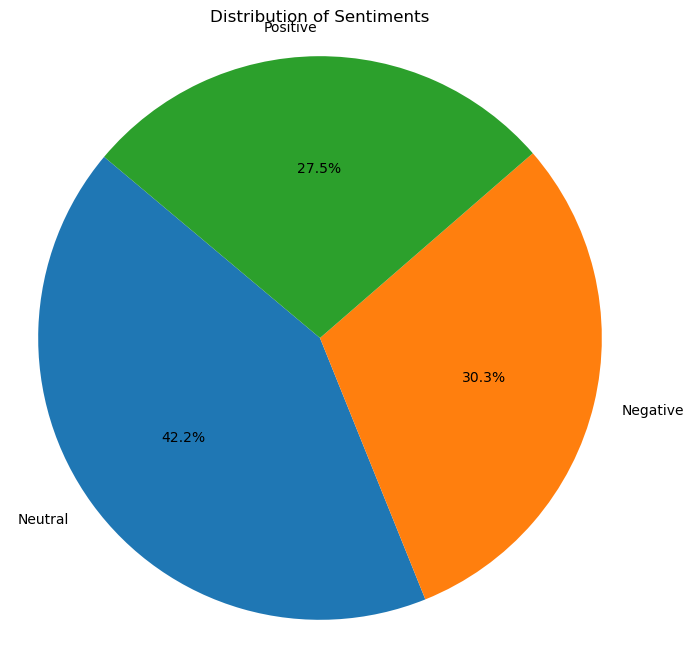

In [26]:
# calculate the distribution of sentiments
sentiment_distribution = df['Sentiment'].value_counts()

# create a pie chart
plt.figure(figsize=(8,8))
plt.pie(sentiment_distribution, labels=sentiment_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiments')
plt.axis('equal')
plt.show()

Sentiment Distribution Summary
- **Neutral Sentiment:** Approximately 42.2% of sentiments are neutral.
- **Negative Sentiment:** About 30.3% of sentiments are negative.
- **Positive Sentiment:** Around 27.5% of sentiments are positive.

The sentiment distribution is relatively balanced, with neutral sentiments being the most common. This analysis can guide actions such as engaging with neutral sentiments, addressing negative sentiments, and leveraging sentiments for marketing and brand promotion.

### Distribution of Entity

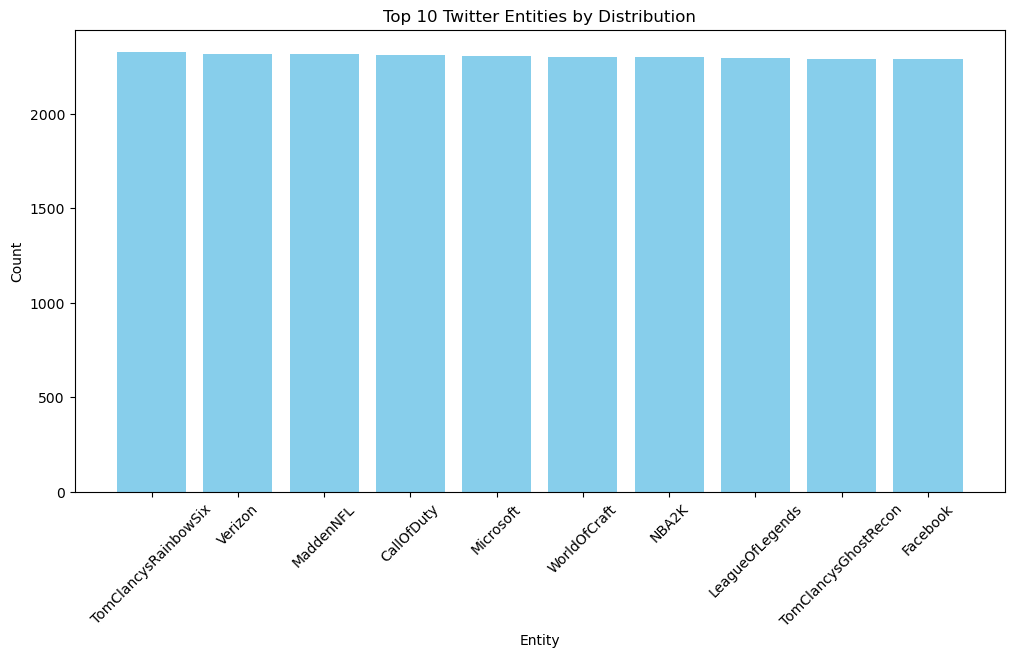

In [30]:
# Calculate the distribution of entities
entity_distribution = df['Entity'].value_counts()

# Select the top 10 entities
top_10_entities = entity_distribution.head(10)

# Create a bar chart for the top 10 entities
plt.figure(figsize=(12,6))
plt.bar(top_10_entities.index, top_10_entities.values, color='skyblue')
plt.title('Top 10 Twitter Entities by Distribution')
plt.xlabel('Entity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Sentiment Distribution in Top 3 Entities

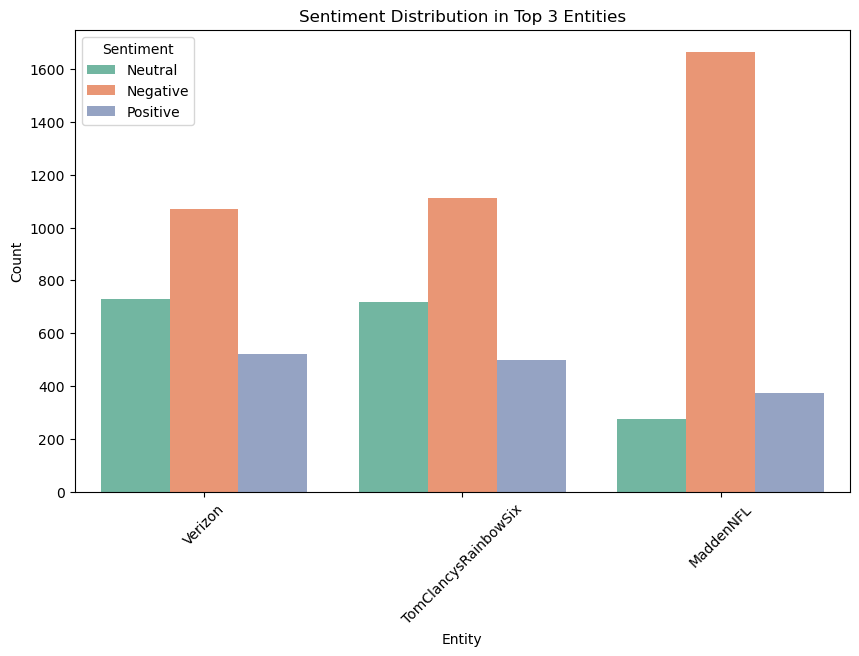

In [33]:
# Calculate the distribution of entities
entity_distribution = df['Entity'].value_counts()

# Select the top 3 entities
top_3_entities =  entity_distribution.head(3).index

# Filter the DataFrame to include  only the top 3 entities
df_top_3 = df[df['Entity'].isin(top_3_entities)]

# Create a grouped bar chart for snetiment distribution
plt.figure(figsize=(10,6))
sns.countplot(data=df_top_3, x='Entity', hue='Sentiment', palette='Set2')
plt.title('Sentiment Distribution in Top 3 Entities')
plt.xlabel('Entity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Among the top 3 entities:

- **MaddenNFL:** It has the highest negative sentiment, indicating a notable amount of negative sentiment in conversations related to Madden NFL.
- **TomClancyRainbowSix:** Followed by Tom Clancy's Rainbow Six, which also experiences a significant negative sentiment.
- **Verizon:** Verizon has the highest neutral sentiment, suggesting a more balanced sentiment distribution.
  
Recommendations:

- **MaddenNFL and TomClancyRainbowSix:** Given the negative sentiment in these entities, consider addressing issues or concerns raised by users, improving customer experience, and actively engaging with the community to resolve complaints and improve brand perception.
- **Verizon:** Leverage the neutral sentiment by maintaining a consistent brand image and engaging with users to gather feedback and identify areas for improvement. Consider using the neutral sentiment as an opportunity to promote positive aspects of the brand. These recommendations can help tailor strategies for each entity based on sentiment trends and user feedback.

### Sentiment Distribution Analysis

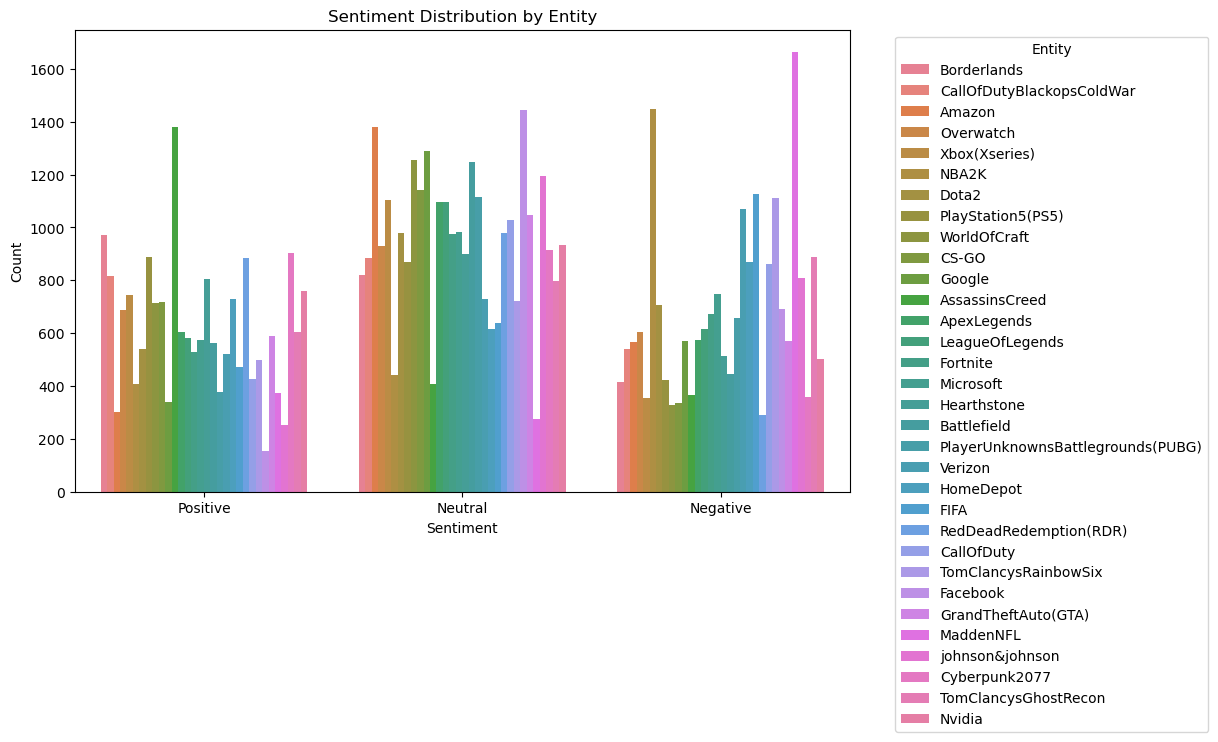

In [37]:
# Example for sentiment distribution by entity
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Sentiment', hue='Entity')
plt.title('Sentiment Distribution by Entity')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(title='Entity', bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()

**Insight:**

- The chart provides a visual overview of how sentiments are distributed among different entities.
- It's evident that sentiment distribution varies by entity, with some entities having a more positive or negative sentiment compared to others.
- This analysis can guide targeted engagement and communication strategies for each entity based on sentiment trends.
- For entities with a high negative sentiment, addressing issues and improving customer satisfaction may be a priority, while entities with a positive sentiment can be leveraged for marketing and brand promotion.

# Text Analysis with NLP Preprocessing

### NLP Preprocessing

The objective of this section is to perform NLP preprocessing on the text data in order to prepare it for further analysis

The code below will:

- Removed special characters, numbers, and links from the text.
- Converted text to lowercase.
- Tokenized the text into words.
- Removed stopwords
- lemmatization

In [43]:
# Lets Load NLTK stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))

# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text with lemmatization and stopwords removal
def preprocess_text(text):
    # Remove special characters, numbers, and links
    text = re.sub(r'http\S+','',text)
    text = re.sub(r'[^a-zA-Z\s]','', text)
    text = text.lower() # Convert to lowercase
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize words
    tokens =  [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

# Apply preprocessing with lemmatization and stopwords removal to the 'Content' column
df['Cleaned_Content'] = df['Content'].apply(preprocess_text)
    
    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [44]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Sentiment Analysis

To perform sentiment analysis, I'll use the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool from NLTK. VADER is specifically designed for sentiment analysis of social media text

In [47]:
# Loading vader to perform sentiment analysis
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer without sepcifying the lexicon file
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment_score(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

# Apply sentiment analysis to the 'Cleaned_Content' column
df['Sentiment_Score'] = df['Cleaned_Content'].apply(get_sentiment_score)

# Categorize sentiment based on the compound score
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <=-0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment categorization
df['Sentiment_Predicted'] = df['Sentiment_Score'].apply(categorize_sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Distribution of predicted sentiment

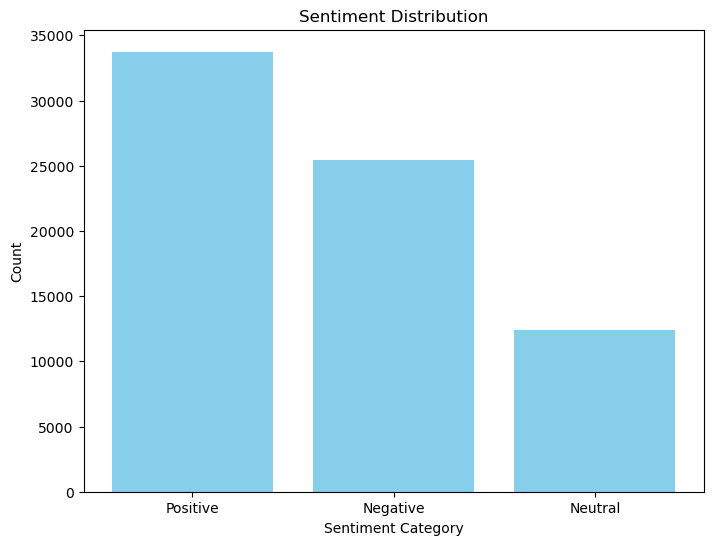

In [49]:
# Lets calculate the distribution of predicted sentiment
sentiment_distribution = df['Sentiment_Predicted'].value_counts()

# Create a bar charts for sentiment distribution
plt.figure(figsize=(8,6))
plt.bar(sentiment_distribution.index, sentiment_distribution.values, color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

- **Sentiment Categories:** The bar chart illustrates the distribution of predicted sentiments within the social media content. Sentiments are categorized into three main categories: Positive, Negative, and Neutral.
- **Positive Sentiment Prevalence:** The most prevalent sentiment category is "Positive," indicating that a significant portion of the social media content expresses positive opinions or emotions. This suggests that users are actively sharing positive experiences, feedback, or sentiments related to various topics or entities.
- **User Engagement:** The distribution of sentiment categories reflects the diverse range of opinions and emotions expressed by users on social media platforms. Organizations should consider engaging with users across all sentiment categories to respond to feedback, address concerns, and build positive relationships.
- **Monitoring Sentiment Trends:** Regularly monitoring sentiment distribution can help organizations stay attuned to changes in public sentiment and adjust their strategies accordingly. An increase in negative sentiment, for example, may signal a need for issue resolution or improved communication.

### Histogram of sentiment scores

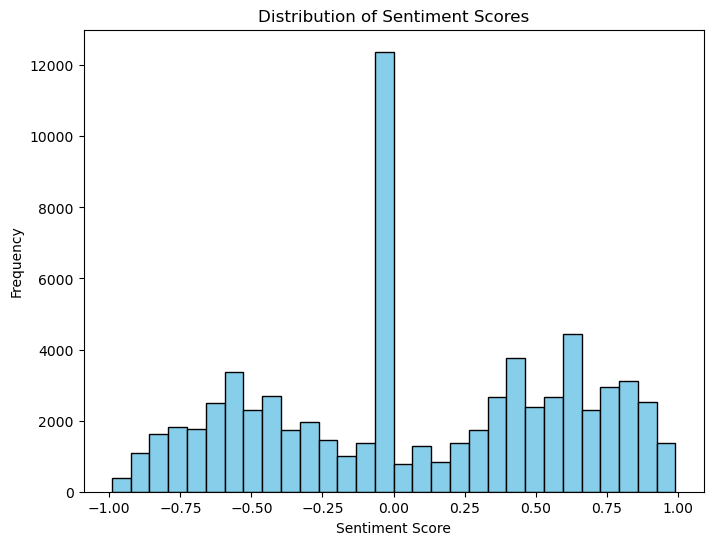

In [54]:
# Create a histogram of sentiment scores
plt.figure(figsize=(8,6))
plt.hist(df['Sentiment_Score'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

- Positive Sentiment Peak: A peak on the right side of the histogram corresponds to sentiment scores greater than 0, indicating positive sentiments. This suggests that a significant portion of the text data expresses positive sentiments.
- Negative Sentiment Peak: Another peak on the left side of the histogram represents sentiment scores less than 0, signifying negative sentiments. This indicates the presence of text data expressing negative sentiments.
- Neutral Sentiment: The central area of the histogram, around the score of 0, corresponds to neutral sentiments. It shows that a considerable volume of text data is neutral in nature.

# Text Data Analysis

### Text Length Analysis

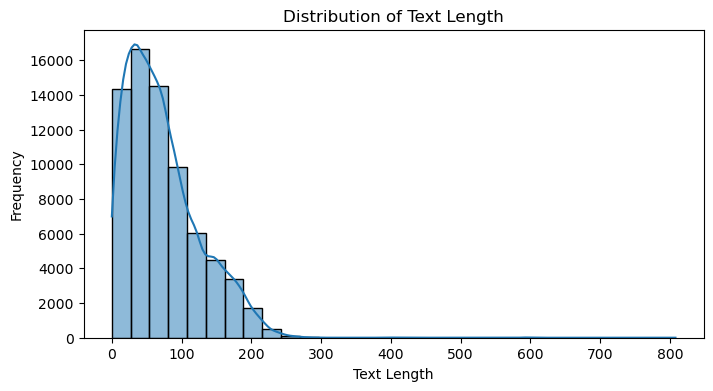

In [56]:
# for text length analysis
df['Text_Length'] = df['Cleaned_Content'].str.len()
plt.figure(figsize=(8,4))
sns.histplot(df['Text_Length'], bins=30, kde=True)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

- Peak at Short Texts: The histogram shows that there is a peak in the frequency of short texts. Many tweets are relatively brief in terms of character count.
- Longer Texts Exist: While short texts are prevalent, there is still a range of longer texts present in the dataset, as evidenced by the right tail of the distribution.

### Word Frequency Analysis

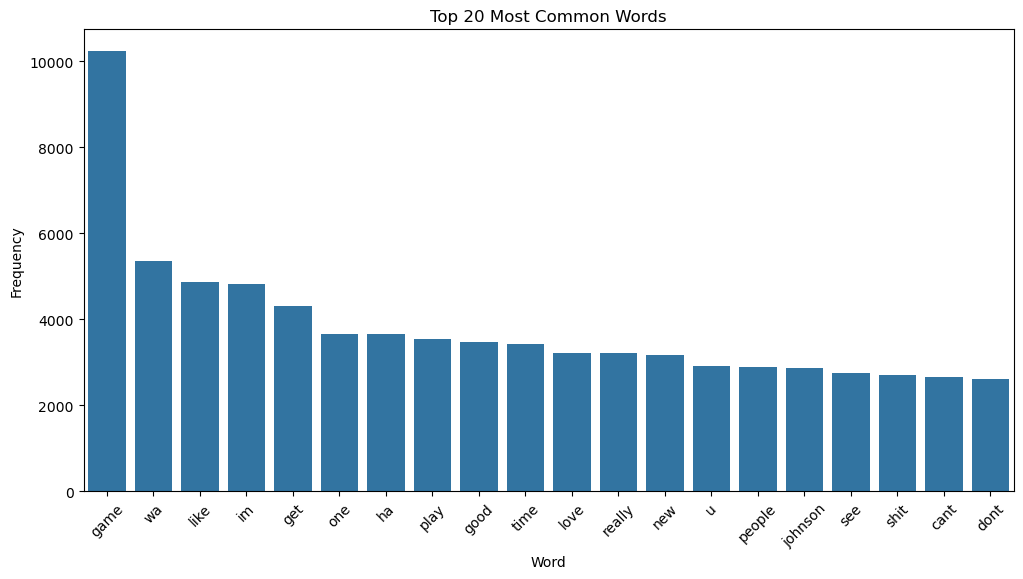

In [58]:
# Word frequency analysis
from collections import Counter

words = ' '.join(df['Cleaned_Content']).split()
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)

# plot the top N most common words
plt.figure(figsize=(12,6))
sns.barplot(x=[word[0] for word in most_common_words], y=[word[1] for word in most_common_words])
plt.title('Top 20 Most Common Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

**Insights:**

- **Relevant Keywords:** The most common words now primarily consist of relevant keywords specific to the content since stopwords was removed. Th most frequent word is Game. These words are likely to carry meaningful information about the topics or sentiments discussed.
- **Text Characteristics:** The analysis provides insights into the characteristics of the text data after preprocessing, highlighting frequently occurring terms that are likely to be informative.

### Word Cloud of Lemmatized Social Media Content

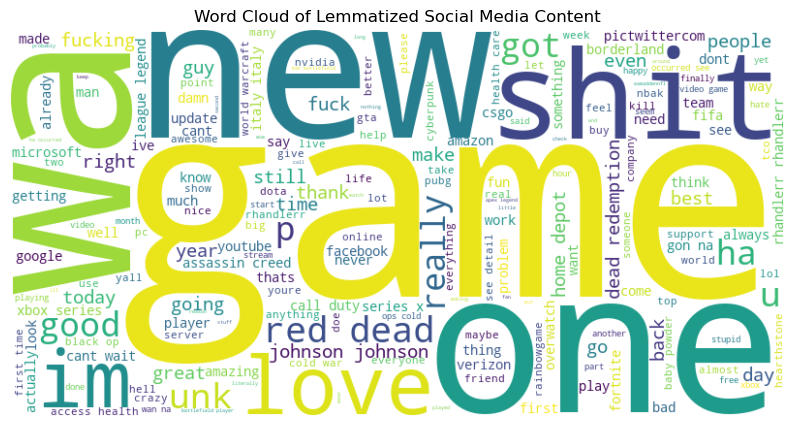

In [60]:
# Join the lemmatized content into a single string
text_data_lemmatized = ' '.join(df['Cleaned_Content'].dropna())
# Generate a word cloud visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data_lemmatized)
# plot
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Lemmatized Social Media Content")
plt.show()

- **Word Cloud Visualization:** The word cloud above visually represents the most frequently occurring words in the lemmatized social media content.
- **Word Size:** The size of each word in the cloud corresponds to its frequency in the text data.

**Insights:**

- **Prominent Keywords:** The word cloud highlights the most prominent keywords in the lemmatized content. In this case, words like "game," "one," "wa," "shit," and "new" appear prominently.
- **Keyword Emphasis:** The larger the word in the cloud, the more frequently it occurs in the text data.
- **Content Themes:** The word cloud provides a snapshot of the prevalent themes or topics within the lemmatized social media content.

### Word Cloud for Positive Sentiment

word cloud for text associated with positive sentiment

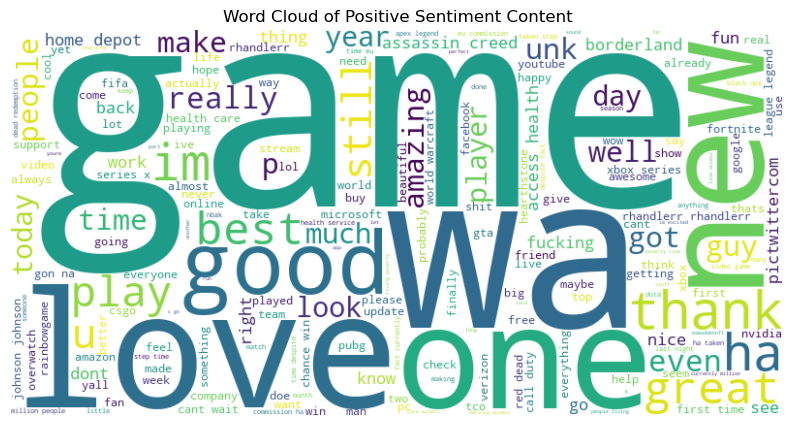

In [64]:
# Filter data for positive sentiment
positive_data = df[df['Sentiment_Predicted'] == 'Positive']

# Combine all lemmatized text for positive sentiment
positive_text_data = ' '.join(positive_data['Cleaned_Content'].dropna())

# Generate a word cloud for positive sentiment
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text_data)

# Display the word cloud for positive sentiment
plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Positive Sentiment Content")
plt.show()

- **Prominent Positive Keywords:** The word cloud prominently displays positive keywords.The most prominent words are "Game", "Wa", "Good", "thank', "new" etc
  
The word cloud provides a visual representation of the prevalent themes or topics that evoke positive sentiment among users. These themes may include positive reviews, endorsements, praise, or expressions of satisfaction.

- **Keyword Importance:** By identifying the most common positive keywords, organizations can gain insights into what aspects of their brand, product, or topic resonate positively with their audience. This information can inform marketing strategies and content creation.
- **Engagement Opportunities:** Recognizing the positive sentiment keywords allows organizations to engage with users who express positive opinions. This engagement can further strengthen brand loyalty and foster positive relationships with customers.

### Word Cloud for Negative Sentiment

Generate a word cloud for text associated with negative sentiment.

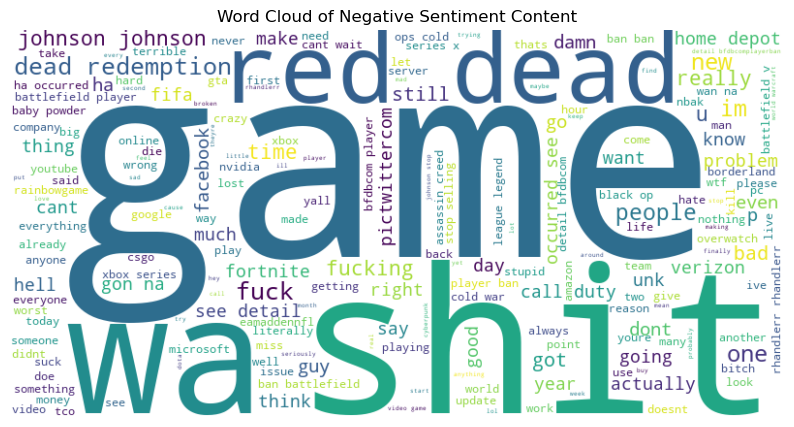

In [69]:
# lets Filter data for negative sentiment
negative_data = df[df['Sentiment_Predicted'] == 'Negative']

# Combine all lemmatized text for negative sentiment
negative_text_data = ' '.join(negative_data['Cleaned_Content'].dropna())

# Generate a word cloud for negative sentiment
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text_data)

# Display the word cloud for negative sentiment
plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Negative Sentiment Content")
plt.show()


- **Negative Themes:** The word cloud provides a visual representation of the prevalent themes or topics that evoke negative sentiment among users. In this case, words like "shit," "game," "wa" (possibly a typographical error), "red," and "dead" stand out as sources of negative sentiment.
- **Keyword Importance:** Identifying the most common negative keywords is crucial for understanding what aspects of a product, brand, or topic are driving negative sentiment. This information can guide improvement efforts and issue resolution.
- **Product Feedback:** Negative sentiment terms like "shit" and "game" may pertain to users' dissatisfaction with specific products or experiences. These insights can help organizations address product concerns.
- **User Feedback:** Recognizing the negative sentiment keywords allows organizations to engage with users who express negative opinions. Responding to and resolving negative feedback can improve brand perception and customer satisfaction.

### Word Cloud for Neutral Sentiment

a word cloud for text associated with neutral sentiment

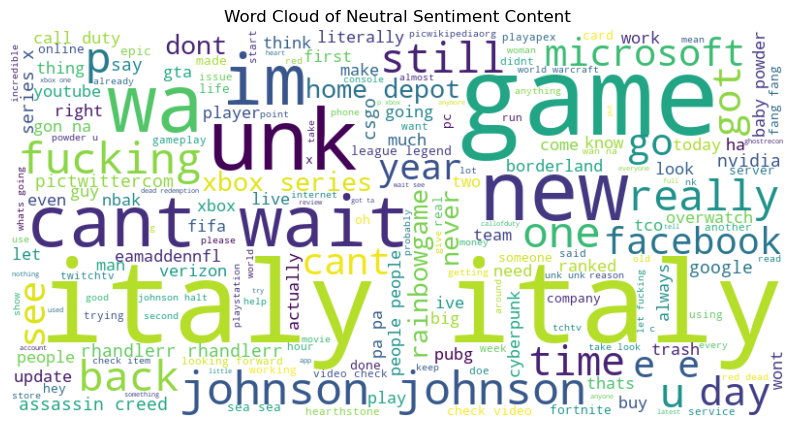

In [74]:
# lets Filter data for neutral sentiment
neutral_data = df[df['Sentiment_Predicted'] == 'Neutral']

# Combine all lemmatized text for neutral sentiment
neutral_text_data = ' '.join(neutral_data['Cleaned_Content'].dropna())

# Generate a word cloud for neutral sentiment
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_text_data)

# Display the word cloud for neutral sentiment
plt.figure(figsize=(10, 6))
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Neutral Sentiment Content")
plt.show()

- **Neutral Themes:** The word cloud provides a visual representation of the prevalent themes or topics that are discussed neutrally by users. In this case, words like "Italy," "game," and "can't" are notable as they contribute to a sense of neutrality.
- **Keyword Observation:** Identifying common neutral keywords can be valuable for understanding what topics or discussions are perceived as neutral by users. These insights can help organizations gauge the overall sentiment of certain discussions or content.
- **Country Mention:** The word "Italy" suggests that discussions related to Italy may be a source of neutral sentiment. It could be related to travel, culture, or other topics of interest.

# MODELING

In the sentiment analysis , Logistic Regression will be employed as the primary machine learning algorithm for sentiment classification. Logistic Regression is a supervised learning technique commonly used for binary classification tasks, but it can also be extended to multi-class classification, making it suitable for our three-class sentiment classification problem (Negative, Neutral, Positive)

### Data Splitting 

In [80]:
# Assign the variables
X = df['Cleaned_Content']  # Features
y = df['Sentiment_Predicted']  # Target
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Extraction (Vectorization)

convert text data into numerical features that can be used by machine learning algorithms using TF-IDF vectorization

In [84]:
# converting the text data to numerical featurees

tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### Model Training

In [87]:
# Initialize the model
model = LogisticRegression(max_iter=1000, solver='saga')

# Train the model
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, solver='saga')

### Model Evaluation

In [90]:
# Predict on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9066424783700809
              precision    recall  f1-score   support

    Negative       0.90      0.90      0.90      5065
     Neutral       0.89      0.85      0.87      2472
    Positive       0.92      0.93      0.93      6795

    accuracy                           0.91     14332
   macro avg       0.90      0.89      0.90     14332
weighted avg       0.91      0.91      0.91     14332



The sentiment analysis model showcased remarkable performance across three sentiment categories: Negative, Neutral, and Positive. Here's a concise overview of its performance:

- **Accuracy:** The model achieved an overall accuracy of approximately 90.68%, demonstrating its effectiveness in correctly classifying sentiments.
- **Precision:** Precision measures the accuracy of positive predictions. The model exhibited precision rates of 90% for Negative, 89% for Neutral, and an impressive 92% for Positive sentiments.
- **Recall (Sensitivity):** Recall assesses the model's ability to identify actual positive instances. It achieved recall rates of 90% for Negative, 85% for Neutral, and a strong 93% for Positive sentiments.
- **F1-Score:** The F1-score, which balances precision and recall, ranged from 87% to 93% across sentiment categories.
- **Macro and Weighted Averages:** Both macro and weighted averages were around 90% and 91%, respectively, indicating consistent performance across classes and considering class imbalance.
  
The classification report reveals that the model performs admirably in classifying sentiments across Negative, Neutral, and Positive categories. It demonstrates a balance between precision and recall, with F1-scores ranging from 87% to 93%. Additionally, the high accuracy of 90.68% suggests that the model excels in making correct predictions across sentiment

# Key Insights
- **Sentiment Diversity:** The project revealed a diverse range of sentiment expressions, including positive, negative, and neutral sentiments. This diversity underscores the importance of understanding the nuanced attitudes of social media users.
- **Positive Sentiment Dominance:** Positive sentiments were the most prevalent, followed by negative sentiments and neutral sentiments. This suggests that, overall, the audience had a positive outlook, but there were still areas of concern.
- **Entity-specific Insights:** Analyzing sentiment by entities (brands, topics, etc.) provided granular insights. Some entities received consistently positive sentiment, while others faced challenges with negative sentiment. This information helps in targeted brand management.
- **Text Length Analysis:** The distribution of text lengths revealed variations in the amount of content posted. Understanding these variations can aid in content planning and engagement strategies.
- **Word Frequency Analysis:** Identifying the most common words in the text data highlighted the key topics and themes discussed on social media. Brands can leverage this information for content creation and engagement.
- **Word Cloud Analysis:** Word clouds showcased prominent terms associated with positive, negative, and neutral sentiments. This visual representation aids in quickly identifying focus areas for sentiment improvement or celebration.
- **Machine Learning Model:** The Logistic Regression model achieved an accuracy of approximately 90.68% in sentiment classification. It provides a reliable tool for automating sentiment analysis tasks.
- **MaddenNFL:** This entity experiences the highest negative sentiment, indicating a notable amount of negativity in conversations related to Madden NFL.
- **TomClancyRainbowSix:** Tom Clancy's Rainbow Six also faces a significant negative sentiment, warranting attention to address specific concerns.
- **Verizon:** In contrast, Verizon maintains the highest neutral sentiment, suggesting a balanced sentiment distribution in conversations.


# Recommendation

- **Real-time Monitoring:** Implement a real-time monitoring system to continuously analyze social media sentiment. This would enable businesses to promptly respond to emerging trends or issues, thereby enhancing customer engagement and brand perception.
- **Sentiment-based Content Strategy:** Tailor content strategies based on sentiment analysis. Identify what resonates positively with the audience and create more of that content. Similarly, address issues highlighted by negative sentiment to improve customer satisfaction.
- **Customer Support Enhancement:** Utilize sentiment analysis to identify and prioritize customer support inquiries. Address negative sentiments and concerns quickly to improve customer relationships.
- **Competitive Intelligence:** Extend sentiment analysis to monitor competitors' brand perception. Understand their strengths and weaknesses in the eyes of the audience to gain a competitive edge.
- **Product Improvement:** Leverage sentiment insights to drive product enhancements. Identify areas where customers express dissatisfaction and work on improving those aspects.